In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

# ---------- Mathematical Tools ----------

def add(a: int, b: int) -> int:
    """Add two integers."""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a."""
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a by b (returns float)."""
    if b == 0:
        return float("inf")  # handle divide by zero gracefully
    return a / b


# ---------- Motivation & Focus Tools ----------

def add_motivation(text: str) -> str:
    """Add a motivational boost to a message."""
    motivational_lines = [
        "You’ve got this! 🚀",
        "Every problem you solve makes you sharper! 💡",
        "Stay confident — progress comes with persistence! 💪"
    ]
    return f"{text} {motivational_lines[0]}"

def add_focus(text: str) -> str:
    """Help refocus and calm the user for better concentration."""
    focus_lines = [
        "Take a deep breath and refocus. 🧘",
        "Let’s break it down step by step.",
        "Focus on one part at a time — you’ll get there."
    ]
    return f"{text} {focus_lines[0]}"


# ---------- Bind Tools to LLM ----------

tools = [add, subtract, multiply, divide, add_motivation, add_focus]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)



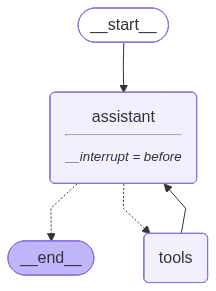

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

tools = [add, subtract]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Run until interruption (before assistant responds)
initial_input = {"messages": [HumanMessage(content="Multiply 5 and 10")]}
thread = {"configurable": {"thread_id": "basic-1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 10


In [6]:
# Get the current state
state = graph.get_state(thread)
print("Before edit:", state.values["messages"][-1].content)

# Manually edit the message
state.values["messages"][-1].content = "Subtract 30 from 45"
graph.update_state(thread, state.values)

# Resume the graph
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

Before edit: Multiply 5 and 10
================================ Human Message =================================

Subtract 30 from 45
================================== Ai Message ==================================
Tool Calls:
  subtract (call_9MYnHPducRcy9drGmedcJbc1)
 Call ID: call_9MYnHPducRcy9drGmedcJbc1
  Args:
    a: 45
    b: 30
================================= Tool Message =================================
Name: subtract

15


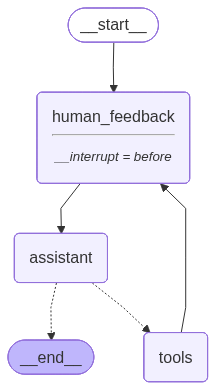

In [7]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# here we need to get user input

In [9]:
# Input
initial_input = {"messages": "3*(4+5)"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

3*(4+5)
================================ Human Message =================================

add 10 +2
================================== Ai Message ==================================
Tool Calls:
  add (call_jfCQVU8NAm9lQ7cUNBatF0yF)
 Call ID: call_jfCQVU8NAm9lQ7cUNBatF0yF
  Args:
    a: 10
    b: 2
  add (call_uNgEZAfeltii9gBE2fBff196)
 Call ID: call_uNgEZAfeltii9gBE2fBff196
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: add

9


In [10]:
	
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================
Tool Calls:
  subtract (call_vWThwE9SjQpv1tu6totp90q6)
 Call ID: call_vWThwE9SjQpv1tu6totp90q6
  Args:
    a: 3
    b: 0
================================= Tool Message =================================
Name: subtract

3


# editing graph in langgraph studio

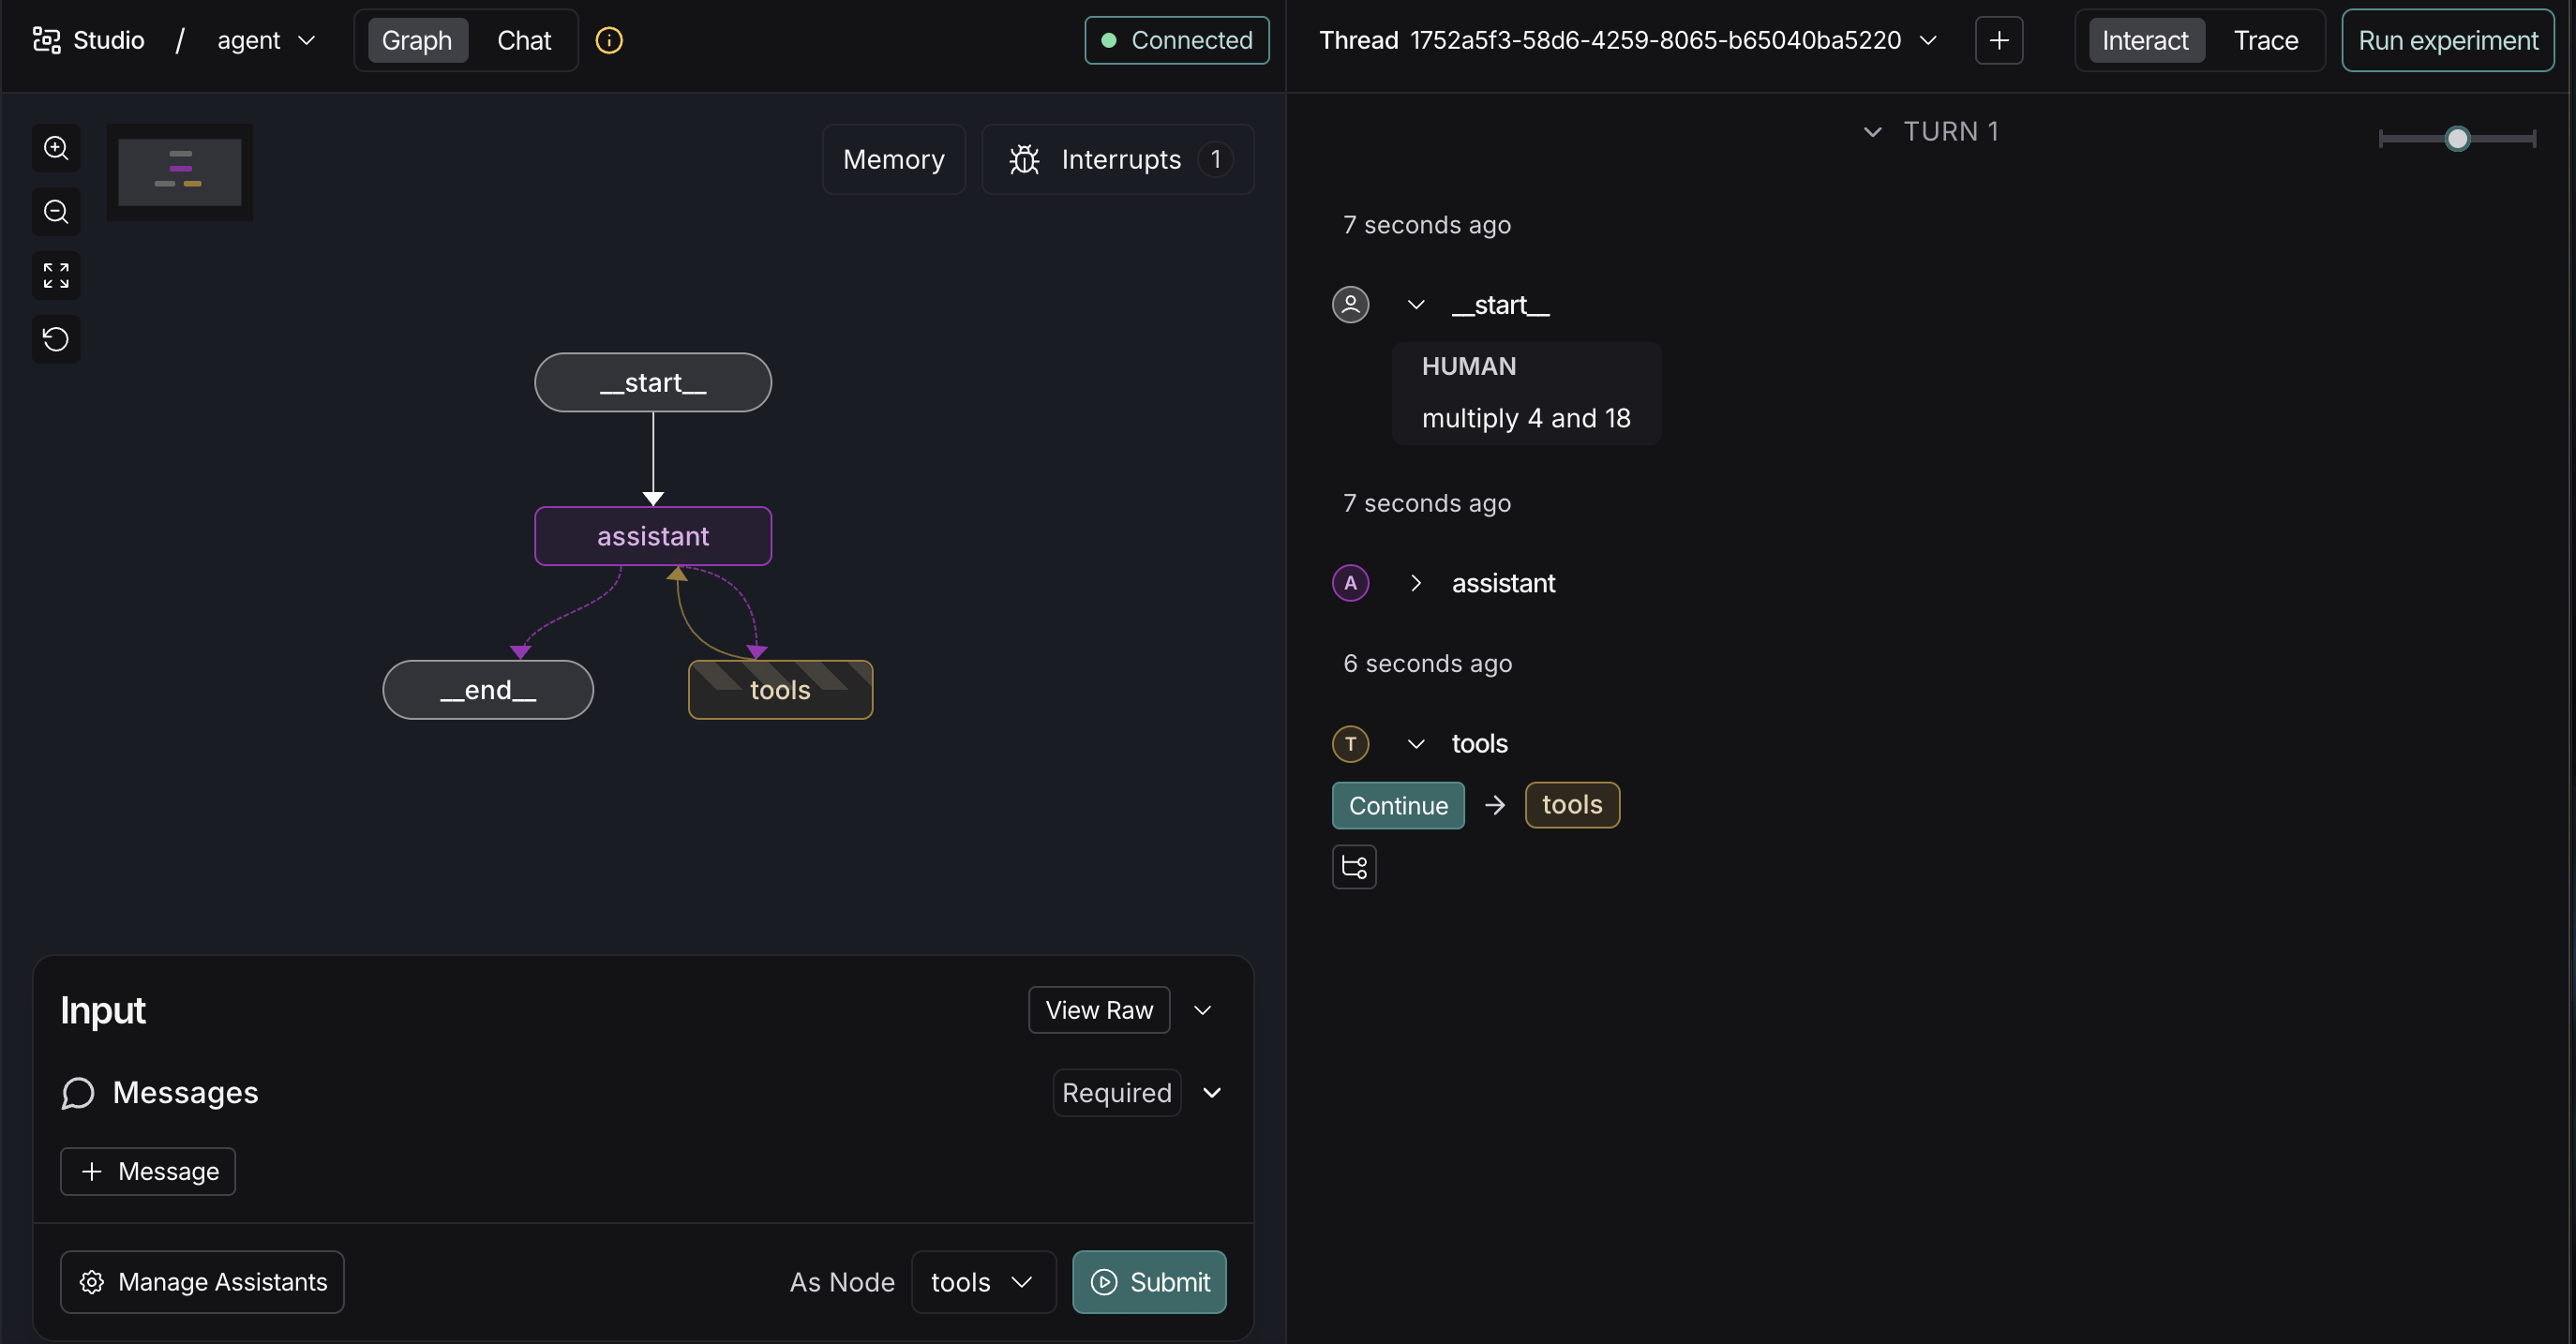
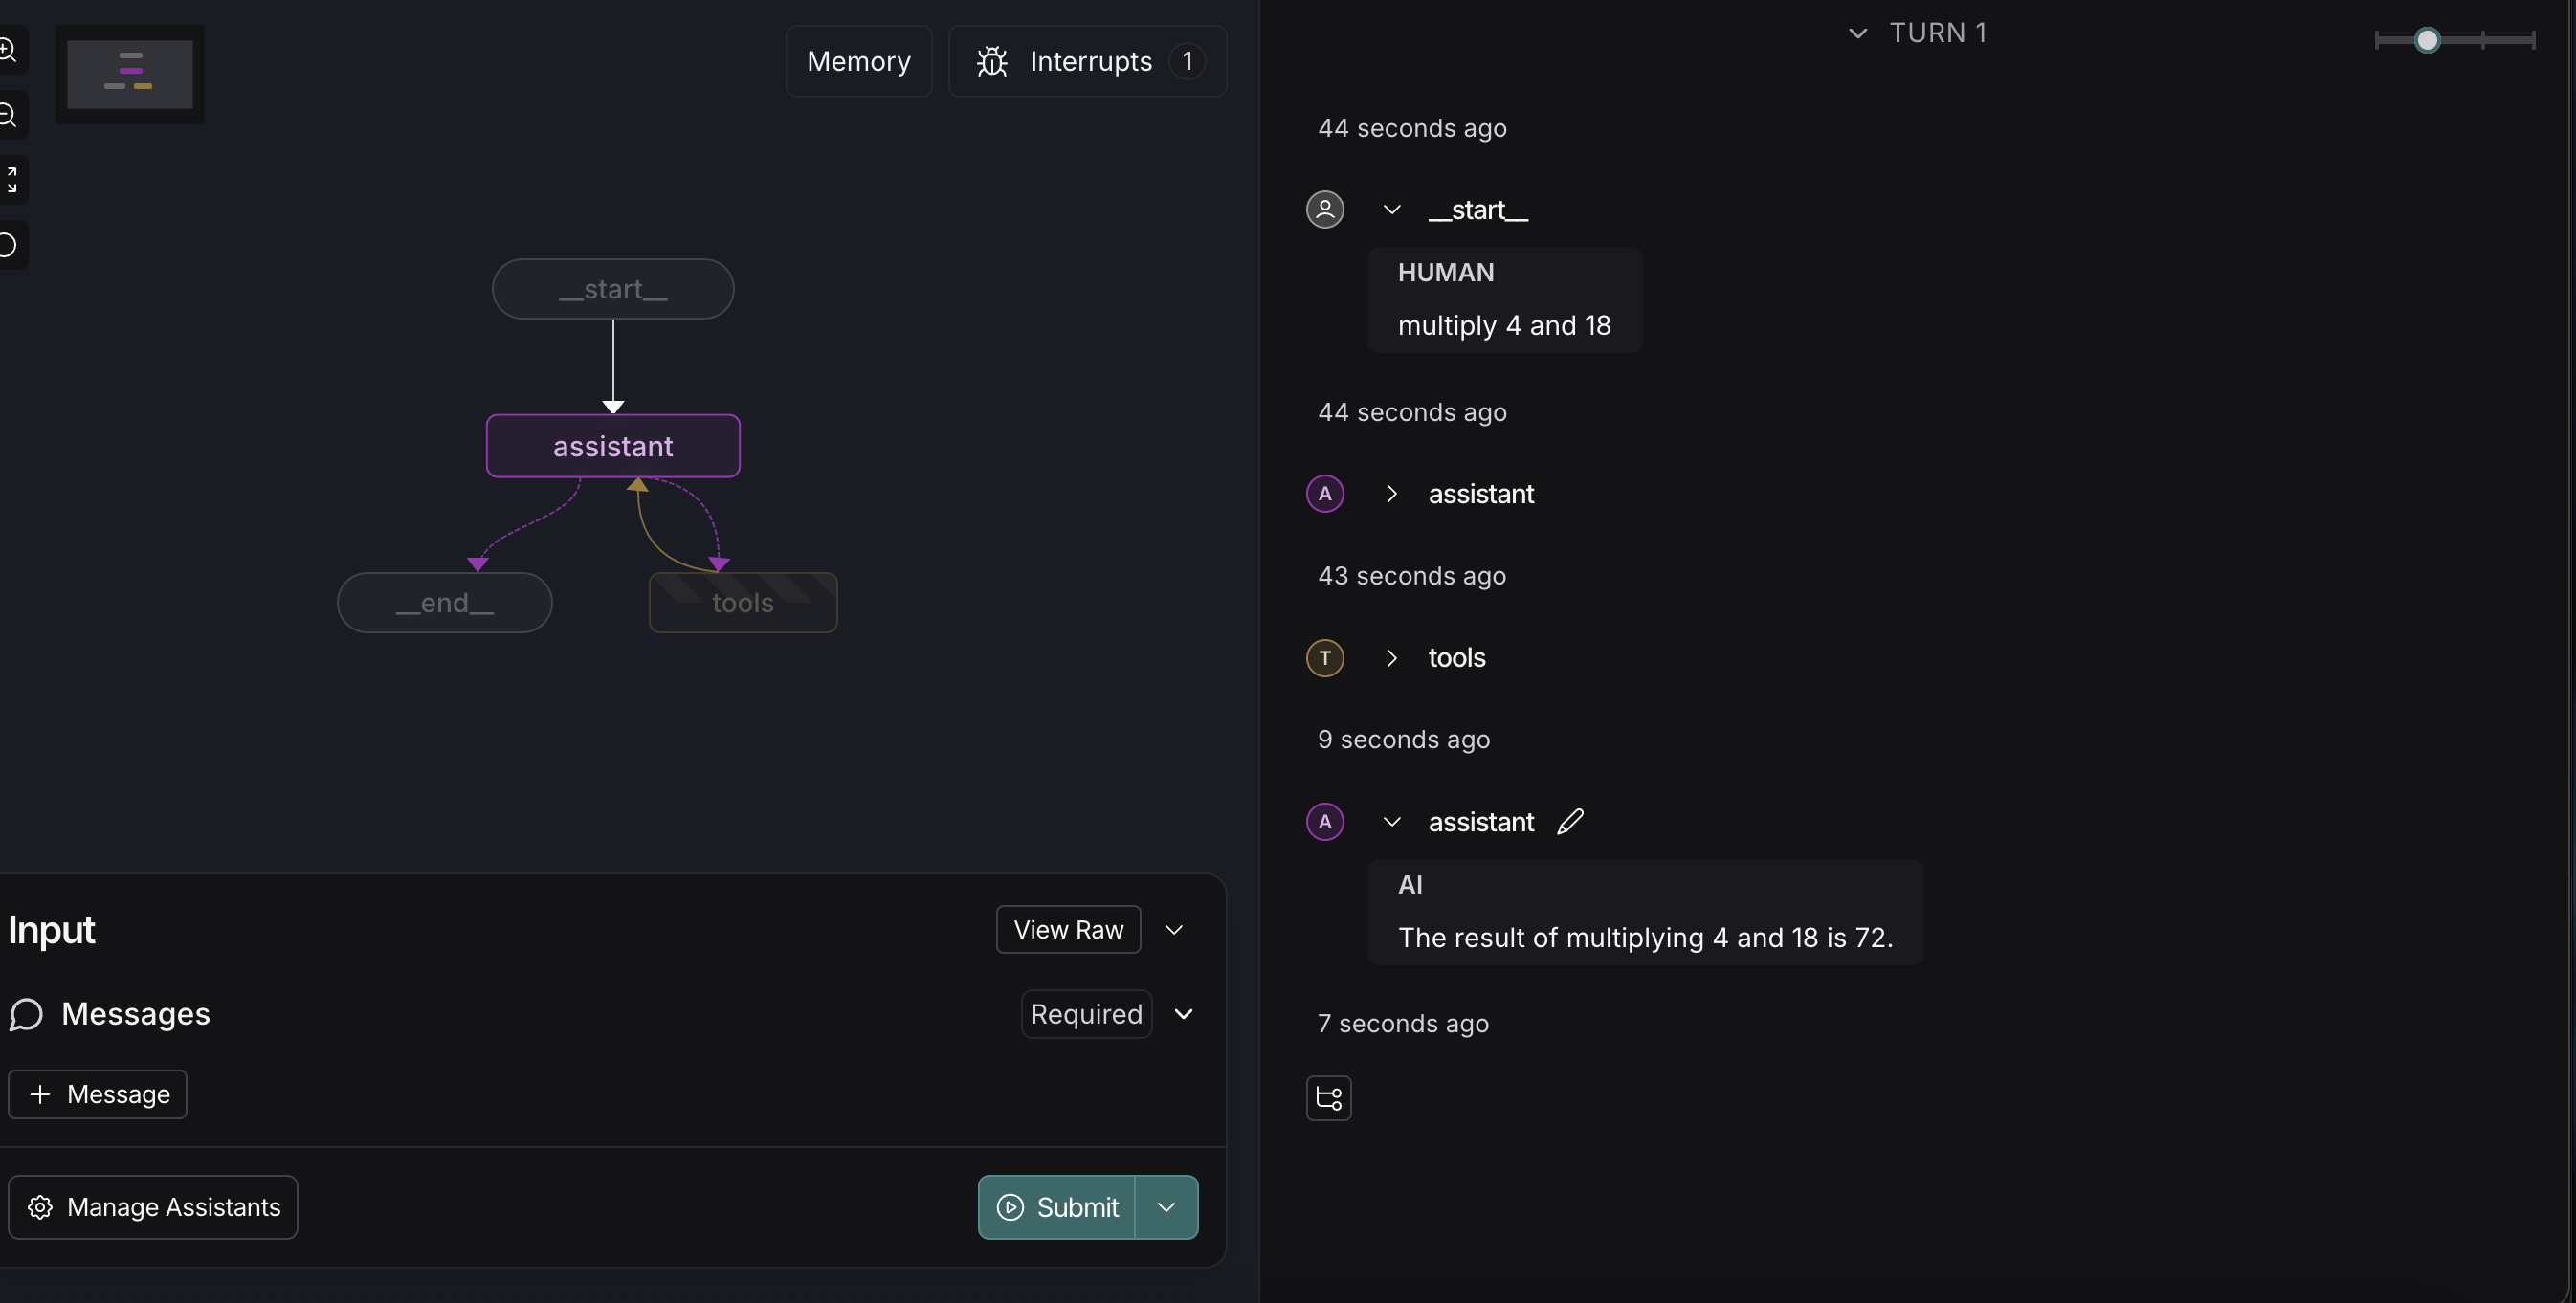

In [11]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [12]:
initial_input = {"messages": "SUBTRACT 38 FROM 42"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'SUBTRACT 38 FROM 42', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '51ff74e1-c37c-4b62-83c4-13335f5e6f93'}
--------------------------------------------------


In [13]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'SUBTRACT 38 FROM 42',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '51ff74e1-c37c-4b62-83c4-13335f5e6f93'}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e65f75b6-0a77-583d-f612-890a89d78fea',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': 'cdc11686-0bc0-41a6-a606-141f7c4a16e9',
  'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '1.0.1',
  'langgraph_api_version': '0.4.42',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019a26a8-f459-748a-b8

In [14]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'SUBTRACT 38 FROM 42',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '51ff74e1-c37c-4b62-83c4-13335f5e6f93'}

In [15]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': 'a883ecbf-a1b9-44f2-a643-3cfa4f3b37cb',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3585-13e6-612a-8001-6935261b0ade'},
 'configurable': {'thread_id': 'a883ecbf-a1b9-44f2-a643-3cfa4f3b37cb',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3585-13e6-612a-8001-6935261b0ade'},
 'checkpoint_id': '1f0b3585-13e6-612a-8001-6935261b0ade'}